# Mobile Phone Tariff Recomendation

In our possesion information about mobile operator clients that use "Ultra" and "Smart" tariffs. We need to build model to recommend to customers optimal for them tariff. Model Accuracy hos to be not less than 0.75.

Data describtion:
 - сalls — number of calls per month,
 - minutes — summury calls duration per month in minutes,
 - messages — number of sms per month,
 - mb_used — internet traffic per month in mb,
 - is_ultra — tariff («Ultra» — 1, «Smart» — 0).

## Data Exploration

In [1]:
#libraries and data importing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv('/datasets/users_behavior.csv')

In [2]:
#a look at the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
df.sample(10)

,calls,minutes,messages,mb_used,is_ultra
2249,46.0,314.16,48.0,16684.31,1
2690,22.0,161.37,24.0,3805.40,1
2712,94.0,587.74,26.0,19213.87,0
452,26.0,198.05,19.0,11336.44,0
965,81.0,542.22,21.0,15356.16,0
1393,72.0,462.96,1.0,11958.39,0
542,107.0,729.44,153.0,32990.68,1
1323,74.0,492.63,2.0,27383.18,1
675,31.0,176.40,31.0,16673.38,0
1553,37.0,296.79,17.0,9979.44,0


In [4]:
df.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


In [5]:
#convert float to integer
cols = ['calls', 'messages']
for col in cols:
    df[col] = df[col].astype(int)

df.head()

,calls,minutes,messages,mb_used,is_ultra
0,40,311.90,83,19915.42,0
1,85,516.75,56,22696.96,0
2,77,467.66,86,21060.45,0
3,106,745.53,81,8437.39,1
4,66,418.74,1,14502.75,0


(<seaborn.axisgrid.PairGrid at 0x7f71e29651d0>,
 Text(0.5, 1.05, 'Scatter matrix for mobile data'),
              calls   minutes  messages   mb_used
 calls     1.000000  0.982083  0.177385  0.286442
 minutes   0.982083  1.000000  0.173110  0.280967
 messages  0.177385  0.173110  1.000000  0.195721
 mb_used   0.286442  0.280967  0.195721  1.000000)

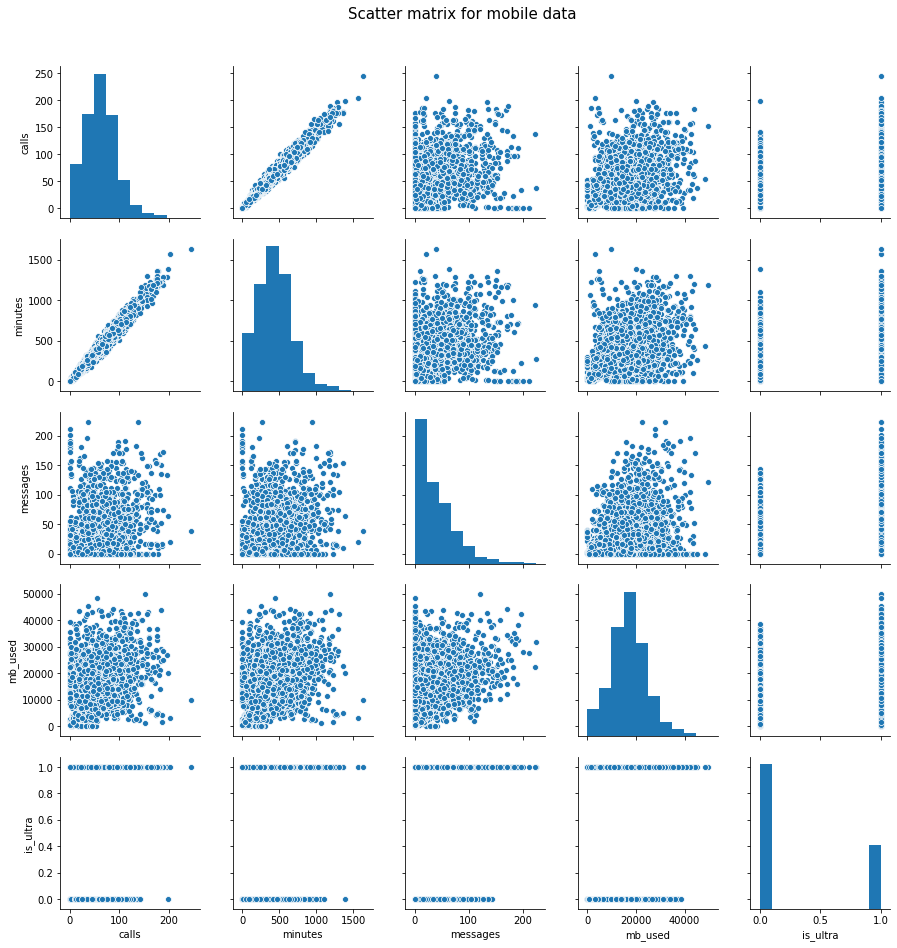

In [6]:
#check multicollinearity
def data_pairplot(dataset):
    plot = sns.pairplot(dataset)
    return (plot, plot.fig.suptitle('Scatter matrix for mobile data', fontsize=15, y=1.05), 
            dataset[['calls', 'minutes', 'messages', 'mb_used']].corr())
    
data_pairplot(df)

### Conclusion

Data explored. Turns out that calls strongly correlated with munites. Drop one of the features to avoid influence of multicollinearity on model.


## Data Preprocessing

In [7]:
#brake data off on train, valid and test
train_valid, test = train_test_split(df, test_size=0.2, stratify=df['is_ultra'])
train, valid = train_test_split(train_valid, test_size=0.25, stratify=train_valid['is_ultra'])

features_train = train.drop(['is_ultra', 'calls'], axis=1)
target_train = train['is_ultra']

features_valid = valid.drop(['is_ultra', 'calls'], axis=1)
target_valid = valid['is_ultra']

features_test = test.drop(['is_ultra', 'calls'], axis=1)
target_test = test['is_ultra']

#check samples sizes
samples = [train, valid, test]
for sample in samples:
    print(sample.shape)



(1928, 5)
(643, 5)
(643, 5)


## Machine Learning

In [8]:
#DecisionTreeClassifier at first
best_tree_model = None
best_tree_result = 0

for depth in range(1, 6):
    tree = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    tree.fit(features_train, target_train)
    predictions = tree.predict(features_valid)
    result = accuracy_score(target_valid, predictions) 
    if result > best_tree_result:
        best_tree_max_depth = depth
        best_tree_result = result
        best_tree_model = tree

print("Accuracy of the best model:", best_tree_result)
print("Max_depth of the best model:", best_tree_max_depth)

Accuracy of the best model: 0.80248833592535
Max_depth of the best model: 3


In [9]:
#then RandomForestClassifier
best_forest_model = None
best_forest_result = 0
criterions = ['gini', 'entropy']

for est in range(1, 11):
    for depth in range(1, 6):
        for crit in criterions:
            rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth = depth, criterion = crit)  
            rf.fit(features_train, target_train)
            result = rf.score(features_valid, target_valid)
            if result > best_forest_result:
                best_forest_model = rf
                best_forest_result = rf.score(features_valid, target_valid)
                best_est = est
                best_forest_max_depth = depth
                best_crit = crit

print("Accuracy of the best model:", best_forest_result)
print("n_estimators of the best model:", best_est)
print("Max_depth of the best model:", best_forest_max_depth)
print("Criterion of the best model:", best_crit)

Accuracy of the best model: 0.8055987558320373
n_estimators of the best model: 3
Max_depth of the best model: 4
Criterion of the best model: gini


In [10]:
#LogisticRegression
best_regression_model = None
best_regression_result = 0
solver_types = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
C_values = [1000000 ,100000, 10000, 1000, 100, 10, 1.0, 0.1, 0.01, 0.001, 0.0001, 0.00001]
penalty_types = ['l1', 'l2', 'elasticnet', 'none']

for solver_type in solver_types:
    for penalty_type in penalty_types:
        for C_value in C_values:
            lr = LogisticRegression(random_state=12345, solver = solver_type, penalty = 'l2', C = C_value)
            lr.fit(features_train, target_train)
            result = lr.score(features_valid, target_valid)
            if result > best_regression_result:
                best_regression_model = lr
                best_regression_result = result
                best_solver = solver_type
                best_C = C_value
                best_penalty = penalty_type

    
print("Accuracy of the best model:", best_regression_result)
print("Solver of the best model:", best_solver)
print("Penalty of the best model:", best_penalty)
print("C of the best model:", best_C)

Accuracy of the best model: 0.7573872472783826
Solver of the best model: newton-cg
Penalty of the best model: l1
C of the best model: 1e-05


                        accuracy
best_tree_result        0.802488
best_forest_result      0.805599
best_regression_result  0.757387


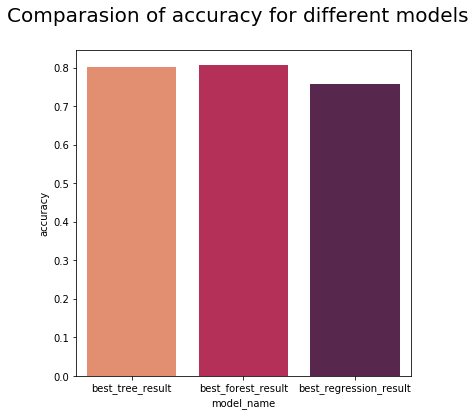

In [11]:
#compare results on validation
results = pd.DataFrame({'accuracy' : [best_tree_result, best_forest_result, best_regression_result]}, 
                       index = ['best_tree_result', 'best_forest_result', 'best_regression_result']
)

print(results)

plt.figure(figsize=(6,6))
sns.barplot(x= results.index, y=results['accuracy'], palette="rocket_r")
plt.suptitle('Comparasion of accuracy for different models', fontsize=20)
plt.xlabel('model_name')
plt.ylabel('accuracy')
plt.show()

### Conlusion

After simple enumeration cycles we found optimal hyperparameters. RandomForestClassifier demonstrates the best resultes. DecisionTreeClassifier - almost the same. LogisticRegression accuracy is fewer.
 

## Model Testing

In [12]:
#learn best models on train+valid
train_valid_features = train_valid.drop(['is_ultra', 'calls'], axis=1) 
train_valid_target = train_valid['is_ultra']

best_tree_model = DecisionTreeClassifier(random_state=12345, max_depth=best_tree_max_depth) 
best_tree_model.fit(train_valid_features, train_valid_target)

best_forest_model = RandomForestClassifier(random_state=12345, n_estimators=best_est, max_depth = best_forest_max_depth, criterion = best_crit)  
best_forest_model.fit(train_valid_features, train_valid_target)

best_regression_model = LogisticRegression(random_state=12345, solver = best_solver, penalty = 'l2', C = best_C)
best_regression_model.fit(train_valid_features, train_valid_target)

LogisticRegression(C=1e-05, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=12345, solver='newton-cg', tol=0.0001,
                   verbose=0, warm_start=False)

                        accuracy
best_tree_result        0.797823
best_forest_result      0.799378
best_regression_result  0.748056


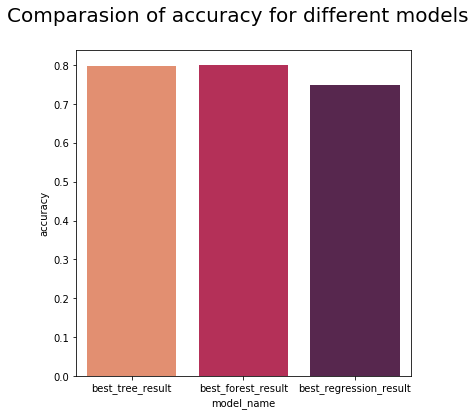

In [13]:
#check on test sample
models = [best_tree_model, best_forest_model, best_regression_model]
results = []
for model in models:
    
    results.append(model.score(features_test, target_test))

results = pd.DataFrame(data = results, 
                       index = ['best_tree_result', 'best_forest_result', 'best_regression_result'], 
                       columns = ['accuracy']
)
print(results) 

plt.figure(figsize=(6,6))
plot = sns.barplot(x= results.index, y=results['accuracy'], palette="rocket_r")
plt.suptitle('Comparasion of accuracy for different models', fontsize=20)
plt.xlabel('model_name')
plt.ylabel('accuracy')
plt.show()



### Conclusion

Models performances have aproved on test

## Model Adequacy Checking

In [14]:
#assume that model output is always 1
ones = target_test ** 0

models = [best_tree_model, best_forest_model, best_regression_model]
results = []
for model in models:
    results.append(model.score(features_test, ones))

results = pd.DataFrame(data = results, 
                       index = ['best_tree_result', 'best_forest_result', 'best_regression_result'], 
                       columns = ['accuracy']
)

print(results)


                        accuracy
best_tree_result        0.178849
best_forest_result      0.189736
best_regression_result  0.073095


In [15]:
#DummyClassifier

dc_results = []
for model in models:
    dummy_clf = DummyClassifier(strategy="most_frequent", random_state = 12345)
    dummy_clf.fit(features_test, target_test)
    dummy_clf.predict(features_test)
    dc_results.append(dummy_clf.score(features_test, target_test))

dc_results = pd.DataFrame(data = dc_results, 
                       index = ['best_tree_result', 'best_forest_result', 'best_regression_result'], 
                       columns = ['accuracy']
)

print(dc_results)

                        accuracy
best_tree_result        0.693624
best_forest_result      0.693624
best_regression_result  0.693624


### Conclusion

Model performances are not so far from DummyClassifier results ;)


## General Conclusion

In this project we've built DecisionTreeClassifier, RandomForestClassifier, LogisticRegression models to give tariff recomendation to mobile operator customers. Performances of the models are better then DummyClassifier results, but not so far.
